# Statistical Analysis of Data

## Environment Settings

An statistical Analysis of the data captured will be performed.

The environment configuration is the following:

- A rectangle area is used whose dimension is 2 x 1.5 meters. 
- A custom robot similar to an epuck was used.
- The robot starts in the middle of the arena.
- The robot moves in a random fashion way around the environment avoiding obstacles.
- The robot has 8 sensors that measure the distance between the robot and the walls.
- Some noise was introduced in the sensors measurements of the robot using the concept of [lookup tables](https://cyberbotics.com/doc/reference/distancesensor) in the Webots simulator which according to Webots documentation "The first column of the table specifies the input distances, the second column specifies the corresponding desired response values, and the third column indicates the desired standard deviation of the noise. The noise on the return value is computed according to a gaussian random number distribution whose range is calculated as a percent of the response value (two times the standard deviation is often referred to as the signal quality)". The following values were taken:

    -First experiment:
        - (0, 0, 0.01)
        - (10, 10, 0.01)
    -Second experiment:
    
        - (0, 0, 0.2)
        - (10, 10, 0.2)
- The simulator runs during 10 minutes in fast mode which is translated into 12 hours of collected data.

In [64]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install keras

import pandas as pd
import tensorflow as tf
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from keras import models
from keras import layers
import matplotlib.pyplot as plt

# First Experiment

In [5]:
csv_file = 'robot_info_dataset-small.csv'
df = pd.read_csv(csv_file)
df.head()

,Unnamed: 0,x,y,theta,dx,dy,dtheta,sensor_1,sensor_2,sensor_3,...,sensor_7,sensor_8,dsensor_1,dsensor_2,dsensor_3,dsensor_4,dsensor_5,dsensor_6,dsensor_7,dsensor_8
0,0,0.988880,0.75,179.999914,-0.002403,-3.434233e-08,-0.000307,1.016671,0.772257,0.758362,...,0.776327,1.036414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.986479,0.75,179.999700,-0.002402,-4.404136e-08,-0.000214,1.023977,0.769891,0.776911,...,0.772796,1.021728,0.007307,-0.002366,0.018549,0.010704,0.016474,0.008077,-0.003531,-0.014686
2,2,0.984077,0.75,179.999550,-0.002402,-4.461517e-08,-0.000150,1.025475,0.764957,0.755931,...,0.763096,1.011234,0.001498,-0.004934,-0.020980,-0.005215,0.014775,-0.001140,-0.009700,-0.010494
3,3,0.981675,0.75,179.999646,-0.002401,1.811730e-09,0.000096,1.002404,0.765992,0.761169,...,0.768402,1.027048,-0.023071,0.001035,0.005239,0.002830,-0.010190,-0.014810,0.005306,0.015814
4,4,0.979275,0.75,179.999719,-0.002401,-3.172477e-08,0.000073,1.031322,0.770209,0.758279,...,0.784118,1.007218,0.028918,0.004218,-0.002891,-0.001779,0.007880,0.001911,0.015716,-0.019830


## Data pre-processing

The data collected 1384848 samples.

In [6]:
df.shape

(1384848, 23)

The data set contains some null values so they should be deleted from the samples.

In [7]:
df = df.dropna()

Now the data will be normalized.

In [8]:
normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df.describe()

,Unnamed: 0,x,y,theta,dx,dy,dtheta,sensor_1,sensor_2,sensor_3,...,sensor_7,sensor_8,dsensor_1,dsensor_2,dsensor_3,dsensor_4,dsensor_5,dsensor_6,dsensor_7,dsensor_8
count,1.384847e+06,1.384847e+06,1.384847e+06,1.384847e+06,1.384847e+06,1.384847e+06,1.384847e+06,1.384847e+06,1.384847e+06,1.384847e+06,...,1.384847e+06,1.384847e+06,1.384847e+06,1.384847e+06,1.384847e+06,1.384847e+06,1.384847e+06,1.384847e+06,1.384847e+06,1.384847e+06
mean,5.000000e-01,5.043103e-01,5.022442e-01,5.066361e-01,4.986988e-01,4.977974e-01,4.999973e-01,3.271090e-01,3.311406e-01,3.325766e-01,...,3.401064e-01,3.362420e-01,4.531070e-01,4.571082e-01,4.921013e-01,5.345466e-01,5.522644e-01,5.323369e-01,4.278540e-01,4.592014e-01
std,2.886754e-01,2.954846e-01,2.963533e-01,2.937289e-01,3.235386e-01,3.064571e-01,3.355993e-02,2.032944e-01,2.329466e-01,2.384979e-01,...,2.328287e-01,2.009473e-01,1.981138e-02,2.099583e-02,2.021053e-02,2.187133e-02,2.111011e-02,2.118726e-02,2.121420e-02,2.087997e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.500000e-01,2.407805e-01,2.343989e-01,2.521449e-01,1.653955e-01,1.998177e-01,4.999971e-01,1.606788e-01,1.164520e-01,1.224339e-01,...,1.173001e-01,1.721422e-01,4.479947e-01,4.523809e-01,4.884411e-01,5.308855e-01,5.487057e-01,5.285259e-01,4.230109e-01,4.539795e-01
50%,5.000000e-01,5.046786e-01,5.057731e-01,5.030852e-01,4.975412e-01,4.939680e-01,4.999974e-01,2.913437e-01,3.099246e-01,3.020417e-01,...,3.181929e-01,3.031704e-01,4.521192e-01,4.568127e-01,4.924489e-01,5.355157e-01,5.531776e-01,5.327067e-01,4.275885e-01,4.581827e-01
75%,7.500000e-01,7.702018e-01,7.750610e-01,7.517734e-01,8.246082e-01,8.018908e-01,4.999977e-01,4.689142e-01,5.248440e-01,5.246918e-01,...,5.340601e-01,4.775811e-01,4.566103e-01,4.608929e-01,4.965942e-01,5.399879e-01,5.575024e-01,5.370229e-01,4.317304e-01,4.627662e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## Input and output variables

The data will be split into training, testing and validation sets. 60% of the data will be used for training, 20% for training and 20% of validation.

In [9]:

# train size
test_size_percentage = .2
train_size_percentage = .6
ds_size = normalized_df.shape[0]
train_size = int(train_size_percentage * ds_size)
test_size = int(test_size_percentage * ds_size)

# shuffle dataset
normalized_df = normalized_df.sample(frac=1)

# separate inputs from outputs
inputs = normalized_df[['x', 'y', 'theta']]
targets = normalized_df[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8']]

# train
train_inputs = inputs[:train_size]
train_targets = targets[:train_size]

# test
test_inputs = inputs[train_size:(train_size + test_size)]
test_targets = targets[train_size:(train_size + test_size)]

# validation
validation_inputs = inputs[(train_size + test_size):]
validation_targets = targets[(train_size + test_size):]

## Random Forsest

We are going to fit a random forest tree with 5 trees and each tree will handle $\sqrt n$ number of variables available for splitting at each tree node.

In [16]:
n_features = 8;
max_features = round(math.sqrt(n_features))

reg = RandomForestRegressor(n_estimators=5, max_features=max_features, criterion='mse', verbose=False, n_jobs=1)
reg.fit(train_inputs, train_targets)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=1, oob_score=False,
                      random_state=None, verbose=False, warm_start=False)

In [66]:
print("Features importances x: %f, y: %f, theta: %f" %(reg.feature_importances_[0], reg.feature_importances_[1], reg.feature_importances_[2]))
print()
predictions_targets = reg.predict(test_inputs)

print("R^2 score: %f \n" % reg.score(test_inputs, test_targets))

# Calculate the absolute errors
errors = abs(predictions_targets - test_targets)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:')
print(round(np.mean(np.mean(errors)), 8))
print()

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_targets)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)

print()
print('Accuracy:')
print(round(np.mean(accuracy), 2), '%.')
print()

nmse = np.mean((predictions_targets - test_targets)**2/np.var(test_targets))
print("NMSE")
print(np.mean(nmse))

Features importances x: 0.278818, y: 0.267225, theta: 0.453957

R^2 score: 0.999047 

Mean Absolute Error:
0.00448776


Accuracy:
98.1 %.

NMSE
0.0009723349374928195


/usr/local/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


## Neural Network


As input the neural network receives the x, y coordinates and rotation angle $\theta$. The output are the sensor measurements. The hidden layer uses relu as activation function. The loss function is MSE and it serves as a metric
to minimize the function.

![NN Architecture](nn_architecture.png)

In [59]:
def get_model(train_data):
    # neural network with a 10-neuron hidden layer
    model = models.Sequential()
    model.add(layers.Dense(10, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(8))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return model

In [60]:
k = 5
num_val_samples = len(train_inputs) // k
validation_scores = []
num_epochs = 50
all_mae_histories = []
nmse = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_inputs[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_inputs[:i * num_val_samples],
         train_inputs[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]], axis=0)
    
 
    model = get_model(train_inputs)
    
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=1)
    print(history.history.keys())
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    
    predictions_targets = model.predict(val_data)
    nmse.append(np.mean((predictions_targets - val_targets)**2)/np.var(val_targets))
    

processing fold # 0
Train on 664727 samples, validate on 166181 samples
Epoch 1/50
664727/664727 [==============================] - 729s 1ms/step - loss: 0.0193 - mae: 0.1078 - val_loss: 0.0167 - val_mae: 0.1005
Epoch 2/50
664727/664727 [==============================] - 717s 1ms/step - loss: 0.0179 - mae: 0.1042 - val_loss: 0.0189 - val_mae: 0.1060
Epoch 3/50
664727/664727 [==============================] - 732s 1ms/step - loss: 0.0195 - mae: 0.1095 - val_loss: 0.0207 - val_mae: 0.1133
Epoch 4/50
664727/664727 [==============================] - 713s 1ms/step - loss: 0.0205 - mae: 0.1122 - val_loss: 0.0247 - val_mae: 0.1248
Epoch 5/50
664727/664727 [==============================] - 743s 1ms/step - loss: 0.0197 - mae: 0.1100 - val_loss: 0.0170 - val_mae: 0.1018
Epoch 6/50
664727/664727 [==============================] - 742s 1ms/step - loss: 0.0200 - mae: 0.1111 - val_loss: 0.0190 - val_mae: 0.1072
Epoch 7/50
664727/664727 [==============================] - 667s 1ms/step - loss: 0.0208

664727/664727 [==============================] - 569s 856us/step - loss: 0.0187 - mae: 0.1067 - val_loss: 0.0210 - val_mae: 0.1147
Epoch 8/50
664727/664727 [==============================] - 591s 889us/step - loss: 0.0186 - mae: 0.1066 - val_loss: 0.0198 - val_mae: 0.1101
Epoch 9/50
664727/664727 [==============================] - 573s 862us/step - loss: 0.0186 - mae: 0.1065 - val_loss: 0.0189 - val_mae: 0.1065
Epoch 10/50
664727/664727 [==============================] - 577s 868us/step - loss: 0.0186 - mae: 0.1064 - val_loss: 0.0171 - val_mae: 0.1001
Epoch 11/50
664727/664727 [==============================] - 585s 880us/step - loss: 0.0185 - mae: 0.1063 - val_loss: 0.0212 - val_mae: 0.1144
Epoch 12/50
664727/664727 [==============================] - 599s 902us/step - loss: 0.0185 - mae: 0.1063 - val_loss: 0.0170 - val_mae: 0.1007
Epoch 13/50
664727/664727 [==============================] - 576s 867us/step - loss: 0.0184 - mae: 0.1061 - val_loss: 0.0190 - val_mae: 0.1075
Epoch 14/50
6

664727/664727 [==============================] - 725s 1ms/step - loss: 0.0228 - mae: 0.1187 - val_loss: 0.0179 - val_mae: 0.1052
Epoch 14/50
664727/664727 [==============================] - 718s 1ms/step - loss: 0.0225 - mae: 0.1180 - val_loss: 0.0185 - val_mae: 0.1066
Epoch 15/50
664727/664727 [==============================] - 660s 994us/step - loss: 0.0224 - mae: 0.1178 - val_loss: 0.0207 - val_mae: 0.1138
Epoch 16/50
664727/664727 [==============================] - 641s 964us/step - loss: 0.0225 - mae: 0.1178 - val_loss: 0.0232 - val_mae: 0.1201
Epoch 17/50
664727/664727 [==============================] - 652s 982us/step - loss: 0.0225 - mae: 0.1180 - val_loss: 0.0198 - val_mae: 0.1123
Epoch 18/50
664727/664727 [==============================] - 610s 918us/step - loss: 0.0226 - mae: 0.1182 - val_loss: 0.0198 - val_mae: 0.1102
Epoch 19/50
664727/664727 [==============================] - 606s 912us/step - loss: 0.0226 - mae: 0.1183 - val_loss: 0.0213 - val_mae: 0.1165
Epoch 20/50
664

664727/664727 [==============================] - 576s 867us/step - loss: 0.0344 - mae: 0.1460 - val_loss: 0.0422 - val_mae: 0.1650
Epoch 20/50
664727/664727 [==============================] - 594s 894us/step - loss: 0.0346 - mae: 0.1467 - val_loss: 0.0377 - val_mae: 0.1490
Epoch 21/50
664727/664727 [==============================] - 585s 881us/step - loss: 0.0347 - mae: 0.1469 - val_loss: 0.0378 - val_mae: 0.1548
Epoch 22/50
664727/664727 [==============================] - 596s 897us/step - loss: 0.0348 - mae: 0.1473 - val_loss: 0.0296 - val_mae: 0.1358
Epoch 23/50
664727/664727 [==============================] - 584s 878us/step - loss: 0.0349 - mae: 0.1474 - val_loss: 0.0467 - val_mae: 0.1707
Epoch 24/50
664727/664727 [==============================] - 584s 879us/step - loss: 0.0351 - mae: 0.1476 - val_loss: 0.0331 - val_mae: 0.1453
Epoch 25/50
664727/664727 [==============================] - 588s 884us/step - loss: 0.0352 - mae: 0.1477 - val_loss: 0.0445 - val_mae: 0.1670
Epoch 26/50

664727/664727 [==============================] - 605s 910us/step - loss: 0.0217 - mae: 0.1157 - val_loss: 0.0247 - val_mae: 0.1251
Epoch 26/50
664727/664727 [==============================] - 582s 876us/step - loss: 0.0218 - mae: 0.1158 - val_loss: 0.0196 - val_mae: 0.1103
Epoch 27/50
664727/664727 [==============================] - 603s 907us/step - loss: 0.0217 - mae: 0.1156 - val_loss: 0.0211 - val_mae: 0.1145
Epoch 28/50
664727/664727 [==============================] - 612s 921us/step - loss: 0.0217 - mae: 0.1156 - val_loss: 0.0194 - val_mae: 0.1084
Epoch 29/50
664727/664727 [==============================] - 627s 944us/step - loss: 0.0217 - mae: 0.1157 - val_loss: 0.0215 - val_mae: 0.1165
Epoch 30/50
664727/664727 [==============================] - 618s 929us/step - loss: 0.0217 - mae: 0.1156 - val_loss: 0.0210 - val_mae: 0.1127
Epoch 31/50
664727/664727 [==============================] - 609s 916us/step - loss: 0.0217 - mae: 0.1157 - val_loss: 0.0215 - val_mae: 0.1158
Epoch 32/50

NMSE: 
0.5607586855711927


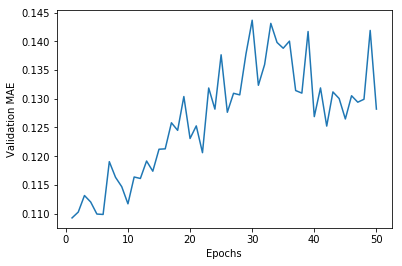

In [65]:
print("NMSE: ")
print(np.mean(nmse))

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


## Second Experiment

In [70]:
csv_file_big = 'robot_info_dataset-big.csv'
df_big = pd.read_csv(csv_file_big)
df_big = df_big.dropna()
print("Shape: ", df_big.shape)

# data normalization
normalized_df_big=(df_big-df_big.min())/(df_big.max()-df_big.min())
normalized_df_big.describe()

Shape:  (1110001, 23)


,Unnamed: 0,x,y,theta,dx,dy,dtheta,sensor_1,sensor_2,sensor_3,...,sensor_7,sensor_8,dsensor_1,dsensor_2,dsensor_3,dsensor_4,dsensor_5,dsensor_6,dsensor_7,dsensor_8
count,1.110001e+06,1.110001e+06,1.110001e+06,1.110001e+06,1.110001e+06,1.110001e+06,1.110001e+06,1.110001e+06,1.110001e+06,1.110001e+06,...,1.110001e+06,1.110001e+06,1.110001e+06,1.110001e+06,1.110001e+06,1.110001e+06,1.110001e+06,1.110001e+06,1.110001e+06,1.110001e+06
mean,5.000000e-01,5.025081e-01,5.137311e-01,5.029814e-01,4.994705e-01,4.991581e-01,4.999980e-01,2.491424e-01,2.369523e-01,2.351461e-01,...,2.566096e-01,2.289987e-01,5.045379e-01,5.023748e-01,4.896848e-01,4.906998e-01,5.382509e-01,4.871383e-01,4.883274e-01,4.827896e-01
std,2.886755e-01,2.726448e-01,2.641271e-01,2.900229e-01,3.232297e-01,3.089054e-01,2.584209e-02,1.373419e-01,1.473428e-01,1.447032e-01,...,1.474400e-01,1.330272e-01,6.525044e-02,6.475618e-02,6.054986e-02,6.117374e-02,5.648393e-02,5.592453e-02,6.472175e-02,6.201368e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.500000e-01,2.579933e-01,2.790194e-01,2.534673e-01,1.670239e-01,1.958396e-01,4.999977e-01,1.389283e-01,1.105549e-01,1.135286e-01,...,1.301613e-01,1.216215e-01,4.728892e-01,4.729581e-01,4.624096e-01,4.609610e-01,5.114513e-01,4.631514e-01,4.599116e-01,4.527951e-01
50%,5.000000e-01,5.109220e-01,5.199541e-01,4.987691e-01,5.005303e-01,5.005646e-01,4.999981e-01,2.249761e-01,2.159326e-01,2.137655e-01,...,2.295932e-01,2.074250e-01,5.045079e-01,5.023648e-01,4.896769e-01,4.907026e-01,5.382418e-01,4.871612e-01,4.882619e-01,4.827387e-01
75%,7.500000e-01,7.450964e-01,7.527783e-01,7.537631e-01,8.264685e-01,8.020884e-01,4.999986e-01,3.356570e-01,3.384592e-01,3.331201e-01,...,3.573809e-01,3.134715e-01,5.361424e-01,5.317868e-01,5.170093e-01,5.204661e-01,5.651213e-01,5.111268e-01,5.167584e-01,5.127842e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


# Input and Output

In [71]:
# train size
ds_size_big = normalized_df_big.shape[0]

# take 40% of the data for trainning only cause NN takes too much time with 60%
train_size_big = int(0.4 * ds_size_big)
test_size_big = int(0.2 * ds_size_big)

# shuffle dataset
normalized_df_big = normalized_df_big.sample(frac=1)

# separate inputs from outputs
inputs_big = normalized_df_big[['x', 'y', 'theta']]
targets_big = normalized_df_big[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8']]

# train
train_inputs_big = inputs_big[:train_size_big]
train_targets_big = targets_big[:train_size_big]

# test
test_inputs_big = inputs_big[train_size_big:(train_size_big + test_size_big)]
test_targets_big = targets_big[train_size_big:(train_size_big + test_size_big)]

# validation
validation_inputs_big = inputs_big[(train_size_big + test_size_big):]
validation_targets_big = targets_big[(train_size_big + test_size_big):]

## Random Forsest

In [72]:
reg2 = RandomForestRegressor(n_estimators=5, max_features=max_features, criterion='mse', verbose=False, n_jobs=1)
reg2.fit(train_inputs_big, train_targets_big)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=1, oob_score=False,
                      random_state=None, verbose=False, warm_start=False)

In [75]:
print("Features importances x: %f, y: %f, theta: %f" %(reg2.feature_importances_[0], reg2.feature_importances_[1], reg2.feature_importances_[2]))
print()
predictions_targets2 = reg2.predict(test_inputs_big)

print("R^2 score: %f \n" % reg2.score(test_inputs_big, test_targets_big))

# Calculate the absolute errors
errors2 = abs(predictions_targets2 - test_targets_big)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:')
print(round(np.mean(np.mean(errors2)), 8))
print()

# Calculate mean absolute percentage error (MAPE)
mape2 = 100 * (errors2 / test_targets_big)

# Calculate and display accuracy
accuracy2 = 100 - np.mean(mape2)

print()
print('Accuracy:')
print(round(accuracy2, 2), '%.')
print()

nmse2 = np.mean((predictions_targets2 - test_targets_big)**2/np.var(test_targets_big))
print("NMSE")
print(np.mean(nmse2))

Features importances x: 0.294433, y: 0.231119, theta: 0.474448

R^2 score: 0.795388 

Mean Absolute Error:
0.04404581


Accuracy:
sensor_1         -inf
sensor_2    78.180000
sensor_3    79.400000
sensor_4    80.850000
sensor_5    79.450000
sensor_6    78.710000
sensor_7    82.540000
sensor_8         -inf
dtype: float64 %.

NMSE
0.20584814916063043


/usr/local/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


## Neural Network

In [86]:
k = 5
num_val_samples_2 = len(train_inputs_big) // k
validation_scores_2 = []
num_epochs = 50
all_mae_histories_2 = []
all_loss_histories_2 = []
nmse_2 = []
histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_inputs_big[i * num_val_samples_2: (i + 1) * num_val_samples_2] 
    val_targets = train_targets_big[i * num_val_samples_2: (i + 1) * num_val_samples_2]
    
    partial_train_data = np.concatenate(
        [train_inputs_big[:i * num_val_samples_2],
         train_inputs_big[(i + 1) * num_val_samples_2:]], axis=0)
    partial_train_targets = np.concatenate(
        [train_targets_big[:i * num_val_samples_2],
         train_targets_big[(i + 1) * num_val_samples_2:]], axis=0)
    
    # neural network with a 10-neuron hidden layer
    model = models.Sequential()
    model.add(layers.Dense(10, activation='relu',
                           input_shape=(train_inputs_big.shape[1],)))
    model.add(layers.Dense(8))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=1)
    print(history.history.keys())
    histories.append(history.history)
    mae_history = history.history['val_mae']
    all_mae_histories_2.append(mae_history)
    all_loss_histories_2.append(history.history['val_loss'])
    
    predictions_targets = model.predict(val_data)
    nmse_2.append(np.mean((predictions_targets - val_targets)**2)/np.var(val_targets))

processing fold # 0
Train on 355200 samples, validate on 88800 samples
Epoch 1/50
355200/355200 [==============================] - 367s 1ms/step - loss: 0.0113 - mae: 0.0825 - val_loss: 0.0111 - val_mae: 0.0815
Epoch 2/50
355200/355200 [==============================] - 362s 1ms/step - loss: 0.0114 - mae: 0.0826 - val_loss: 0.0108 - val_mae: 0.0802
Epoch 3/50
355200/355200 [==============================] - 389s 1ms/step - loss: 0.0114 - mae: 0.0828 - val_loss: 0.0111 - val_mae: 0.0813
Epoch 4/50
355200/355200 [==============================] - 361s 1ms/step - loss: 0.0114 - mae: 0.0829 - val_loss: 0.0114 - val_mae: 0.0835
Epoch 5/50
355200/355200 [==============================] - 403s 1ms/step - loss: 0.0115 - mae: 0.0831 - val_loss: 0.0111 - val_mae: 0.0815
Epoch 6/50
355200/355200 [==============================] - 387s 1ms/step - loss: 0.0113 - mae: 0.0824 - val_loss: 0.0106 - val_mae: 0.0797
Epoch 7/50
355200/355200 [==============================] - 378s 1ms/step - loss: 0.0104 

355200/355200 [==============================] - 348s 979us/step - loss: 0.0135 - mae: 0.0899 - val_loss: 0.0126 - val_mae: 0.0866
Epoch 8/50
355200/355200 [==============================] - 343s 966us/step - loss: 0.0127 - mae: 0.0873 - val_loss: 0.0124 - val_mae: 0.0874
Epoch 9/50
355200/355200 [==============================] - 358s 1ms/step - loss: 0.0122 - mae: 0.0858 - val_loss: 0.0118 - val_mae: 0.0845
Epoch 10/50
355200/355200 [==============================] - 368s 1ms/step - loss: 0.0126 - mae: 0.0874 - val_loss: 0.0124 - val_mae: 0.0855
Epoch 11/50
355200/355200 [==============================] - 351s 988us/step - loss: 0.0129 - mae: 0.0886 - val_loss: 0.0125 - val_mae: 0.0869
Epoch 12/50
355200/355200 [==============================] - 350s 984us/step - loss: 0.0131 - mae: 0.0889 - val_loss: 0.0126 - val_mae: 0.0868
Epoch 13/50
355200/355200 [==============================] - 355s 999us/step - loss: 0.0129 - mae: 0.0880 - val_loss: 0.0126 - val_mae: 0.0873
Epoch 14/50
35520

355200/355200 [==============================] - 376s 1ms/step - loss: 0.0119 - mae: 0.0850 - val_loss: 0.0111 - val_mae: 0.0825
Epoch 15/50
355200/355200 [==============================] - 357s 1ms/step - loss: 0.0120 - mae: 0.0852 - val_loss: 0.0122 - val_mae: 0.0865
Epoch 16/50
355200/355200 [==============================] - 370s 1ms/step - loss: 0.0121 - mae: 0.0856 - val_loss: 0.0109 - val_mae: 0.0811
Epoch 17/50
355200/355200 [==============================] - 377s 1ms/step - loss: 0.0121 - mae: 0.0856 - val_loss: 0.0115 - val_mae: 0.0837
Epoch 18/50
355200/355200 [==============================] - 365s 1ms/step - loss: 0.0121 - mae: 0.0857 - val_loss: 0.0109 - val_mae: 0.0808
Epoch 19/50
355200/355200 [==============================] - 383s 1ms/step - loss: 0.0119 - mae: 0.0849 - val_loss: 0.0123 - val_mae: 0.0868
Epoch 20/50
355200/355200 [==============================] - 389s 1ms/step - loss: 0.0118 - mae: 0.0846 - val_loss: 0.0104 - val_mae: 0.0795
Epoch 21/50
355200/355200

355200/355200 [==============================] - 363s 1ms/step - loss: 0.0096 - mae: 0.0760 - val_loss: 0.0096 - val_mae: 0.0761
Epoch 22/50
355200/355200 [==============================] - 352s 992us/step - loss: 0.0096 - mae: 0.0760 - val_loss: 0.0094 - val_mae: 0.0752
Epoch 23/50
355200/355200 [==============================] - 383s 1ms/step - loss: 0.0096 - mae: 0.0760 - val_loss: 0.0092 - val_mae: 0.0738
Epoch 24/50
355200/355200 [==============================] - 358s 1ms/step - loss: 0.0096 - mae: 0.0760 - val_loss: 0.0092 - val_mae: 0.0740
Epoch 25/50
355200/355200 [==============================] - 347s 977us/step - loss: 0.0096 - mae: 0.0760 - val_loss: 0.0102 - val_mae: 0.0794
Epoch 26/50
355200/355200 [==============================] - 370s 1ms/step - loss: 0.0096 - mae: 0.0760 - val_loss: 0.0096 - val_mae: 0.0751
Epoch 27/50
355200/355200 [==============================] - 342s 962us/step - loss: 0.0097 - mae: 0.0761 - val_loss: 0.0089 - val_mae: 0.0721
Epoch 28/50
355200/

355200/355200 [==============================] - 395s 1ms/step - loss: 0.0092 - mae: 0.0742 - val_loss: 0.0088 - val_mae: 0.0724
Epoch 29/50
355200/355200 [==============================] - 405s 1ms/step - loss: 0.0092 - mae: 0.0743 - val_loss: 0.0088 - val_mae: 0.0728
Epoch 30/50
355200/355200 [==============================] - 419s 1ms/step - loss: 0.0092 - mae: 0.0743 - val_loss: 0.0092 - val_mae: 0.0738
Epoch 31/50
355200/355200 [==============================] - 396s 1ms/step - loss: 0.0092 - mae: 0.0743 - val_loss: 0.0087 - val_mae: 0.0724
Epoch 32/50
355200/355200 [==============================] - 402s 1ms/step - loss: 0.0092 - mae: 0.0743 - val_loss: 0.0090 - val_mae: 0.0730
Epoch 33/50
355200/355200 [==============================] - 445s 1ms/step - loss: 0.0093 - mae: 0.0744 - val_loss: 0.0085 - val_mae: 0.0710
Epoch 34/50
355200/355200 [==============================] - 473s 1ms/step - loss: 0.0093 - mae: 0.0744 - val_loss: 0.0121 - val_mae: 0.0874
Epoch 35/50
355200/355200

NMSE: 
0.5661648773330599


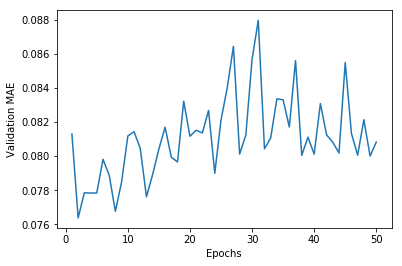

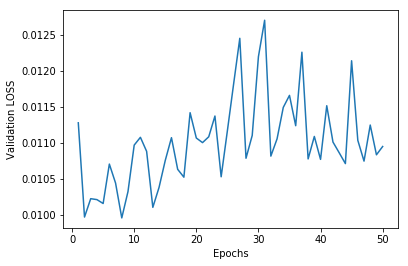

In [91]:
print("NMSE: ")
print(np.mean(nmse_2))

average_mae_history_2 = [np.mean([x[i] for x in all_mae_histories_2]) for i in range(num_epochs)]
plt.plot(range(1, len(average_mae_history_2) + 1), average_mae_history_2)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

average_loss_history_2 = [np.mean([x[i] for x in all_loss_histories_2]) for i in range(num_epochs)]
plt.plot(range(1, len(average_loss_history_2) + 1), average_loss_history_2)
plt.xlabel('Epochs')
plt.ylabel('Validation LOSS')
plt.show()